# Trabalho 5 - Transformada de Hough

Faça um documento jupyter notebook que forneça, com base na transformada de Hough modelada para círculos, a contagem e a descrição (coordenadas dos centros e raio) dos discos grandes presentes na imagem do exemplo (do trabalho 3 - segmentação dos discos claros usando a transformada top-hat). 

-------

Procedimento sugerido:

Use como base o resultado do trabalho 3. Inicialmente, subtraia o resultado do trabalho 3 da imagem original a fim de obter a segmentação dos discos. Em seguida, utilize um filtro para obter as bordas dos discos e binarize o resultado. Por fim, empregue a transformada de Hough para obter as informações desejadas.

-------

In [1]:
import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

# Funções

In [2]:
def img_threshold(img, threshold = 60):
    return threshold < img

In [3]:
def img2binary(img):
    """Binarization of image with threshold given"""
    img[img > 0] = 1
    return img

In [4]:
def sobel(img):
    sobelx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobely = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    gx = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(sobelx, -1)))
    gy = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(sobely, -1)))
    
    return gx + gy

In [5]:
def plota(img):
    num = len(img)
    fig = plt.figure(figsize = (15, 9))
    grid = plt.GridSpec(1, num, fig)
    
    for i in range(num):
        ax = fig.add_subplot(grid[0, i])
        ax.imshow(img[i], cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
    
    return fig

In [ ]:
def remove_straight_edges(img, percent = 0.03):
    if img.max() != 255:
        horizontal = np.copy(img * 255)
        vertical = np.copy(img * 255)
    else:
        horizontal = np.copy(img)
        vertical = np.copy(img)
    
    kernel = np.ones((2, 2), np.uint8)
    
    n_rows, n_cols = img.shape
    horizontal_size = np.int(n_cols * percent)
    horizontal_structure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))
    horizontal = cv.erode(horizontal, horizontalStructure)
    horizontal = cv.dilate(horizontal, horizontalStructure)
    horizontal = cv.bitwise_not(horizontal)
    horizontal_edges = cv.adaptiveThreshold(horizontal, 255, cv.ADAPTIVE_THRESH_MEAN_C,
                                  cv.THRESH_BINARY, 3, -2)
    
    horizontal_edges = cv.dilate(horizontal_edges, kernel)
    horizontal_smooth = np.copy(horizontal)
    horizontal_smooth = cv.blur(horizontal_smooth, (3, 3))
    
    (rows, cols) = np.where(horizontal_edges != 0)
    horizontal[rows, cols] = horizontal_smooth[rows, cols]
    
    vertical_size = np.int(n_rows * percent)
    vertical_structure = cv.getStructuringElement(cv.MORPH_RECT, (1, vertical_size))
    vertical = cv.erode(vertical, verticalStructure)
    vertical = cv.dilate(vertical, verticalStructure)
    vertical = cv.bitwise_not(vertical)
    vertical_edges = cv.adaptiveThreshold(vertical, 255, cv.ADAPTIVE_THRESH_MEAN_C,
                                  cv.THRESH_BINARY, 3, -2)
    
    vertical_edges = cv.dilate(vertical_edges, kernel)
    vertical_smooth = np.copy(vertical)
    vertical_smooth = cv.blur(vertical_smooth, (3, 3))
    
    (rows, cols) = np.where(vertical_edges != 0)
    vertical[rows, cols] = vertical_smooth[rows, cols]


    return cv.bitwise_not(vertical) + cv.bitwise_not(horizontal)

### Estratégia:

    1) Limiariza a entrada e a saída;
    2) Passar filtro mediano na entrada e na saída limiarizados;
    3) Fazer a diferença entra entrada e saída;
    4) Aplicar Sobel na diferença;

## Carregando as images

In [6]:
entrada = cv.imread('../images/cosmos_original.jpg', 0)
saida = cv.imread('../images/img_final.jpg', 0)

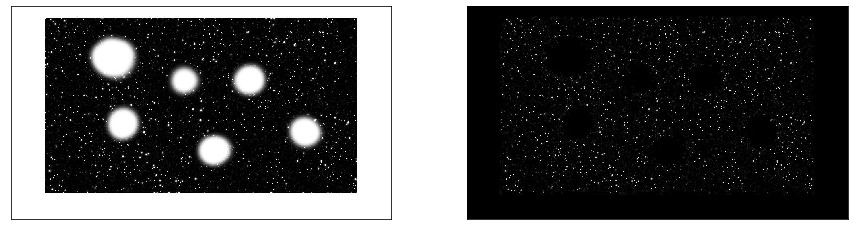

In [7]:
fig = plota([entrada, saida])

In [8]:
entrada_thres = img_threshold(entrada).astype(np.uint8)
saida_thres = img_threshold(saida).astype(np.uint8)

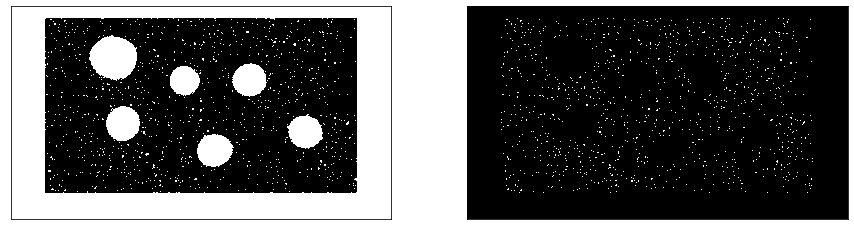

In [9]:
fig = plota([entrada_thres, saida_thres])

In [10]:
entrada_thres_med = cv.medianBlur(entrada_thres, 5)
saida_thres_med = cv.medianBlur(saida_thres, 5)

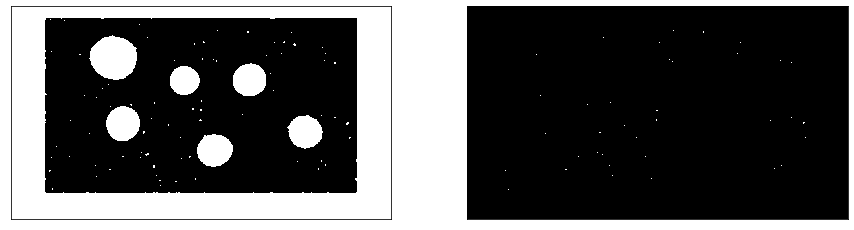

In [11]:
fig = plota([entrada_thres_med, saida_thres_med])

In [12]:
diff_thres_med = entrada_thres_med - saida_thres_med

In [13]:
diff_sob = sobel(diff_thres_med)

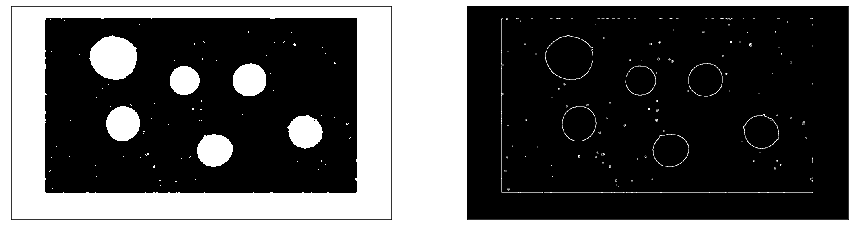

In [14]:
fig = plota([diff_thres_med, diff_sob])

In [15]:
diff_sob_bin = img2binary(np.copy(diff_sob))

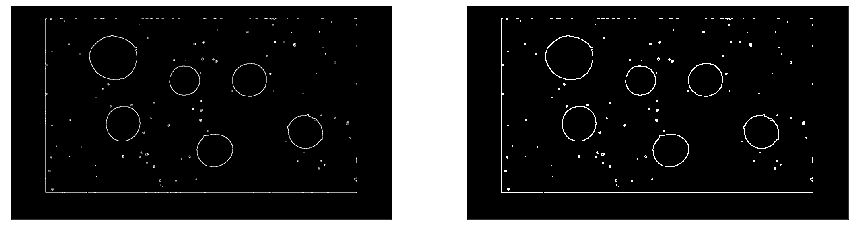

In [16]:
fig = plota([diff_sob, diff_sob_bin])

In [17]:
n_rows, n_cols = diff_sob_bin.shape

In [18]:
theta_step = 1
theta_min = 0
theta_max = 180

theta_size = len(range(theta_min, theta_max, theta_step))
theta_array = np.array(range(theta_min, theta_max + 1, theta_step))

In [19]:
rho_min = 0
rho_max = np.ceil(np.sqrt(n_rows**2 + n_cols**2))
# rho_step = np.ceil((rho_max - rho_min) / theta_size)
rho_step = 1

rho_size = len(range(np.int(rho_min), np.int(rho_max), np.int(rho_step)))

In [20]:
cummulative_matrix = np.zeros((rho_size + 1, theta_size + 1))

In [21]:
for i in range(n_rows):
    for j in range(n_cols):
        if diff_sob_bin[i, j] == 0:
            continue
        
        for theta in theta_array:
            rho = i * np.cos(np.radians(theta)) + j * np.sin(np.radians(theta))
            cummulative_matrix[int(rho), theta] = cummulative_matrix[int(rho), theta] + 1

In [23]:
cummulative_matrix.max()

773.0

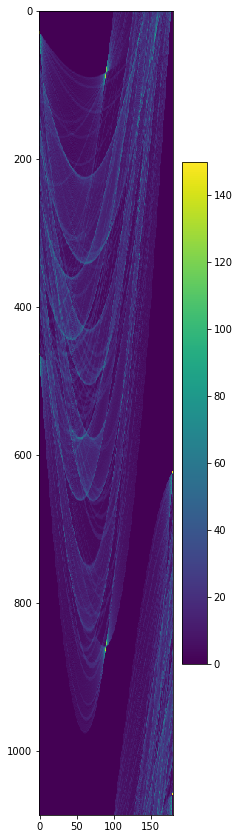

In [72]:
fig = plt.figure(figsize=(3,21))
plt.imshow(cummulative_matrix, vmax = 150)
plt.colorbar()

In [57]:
np.where(cummulative_matrix > 682)

(array([  29,   30,  464,  465,  623, 1058, 1059]),
 array([  0,   0,   0,   0, 180, 180, 180]))